In [1]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import Category10
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [310]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm.csv", index_col=0, usecols=["gene", "BB9", "BB10", "BB17",
                                                                              "BB19", "BB20", "BB21",
                                                                              "BB11", "BB12", "BB18"])
print("Tamanho dos dados:", datos.shape)
datos.head()

Tamanho dos dados: (4293, 9)


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,45.6132,57.7381,35.4817,71.4413,75.5846,59.6099,93.7032,78.2685,75.4577
aaeB,48.4527,42.2968,41.1391,44.0555,47.6292,51.5953,56.3065,69.1718,58.5695
aaeR,49.0572,53.1486,33.4681,55.6848,43.8708,64.5169,51.3741,77.9266,79043.0000
aaeX,66.7322,64.9632,64.3814,81.0705,52586.0000,69.0053,64.9201,69.2443,56966.0000
aas,73.7846,77.6379,77.6300,65.1203,64.7268,77.6184,77.5343,95.9067,93.9019


In [257]:
datos = np.log2(datos+1)

In [4]:
q25 = np.quantile(datos, .25, interpolation="midpoint", axis=0)
q50 = np.quantile(datos, .5, interpolation="midpoint", axis=0)
q75 = np.quantile(datos, .75, interpolation="midpoint", axis=0)

upper = q75 + 1.5*(q75-q25)
lower = q25 - 1.5*(q75-q25)

In [5]:
rg = open("./data/reference_genes.txt", "r", newline="\n")
hkg = [i for i in rg.read().splitlines()]
print("Quantidade de genes housekeeping:", len(hkg))
print("-----------------------------------------------")
print(hkg)

Quantidade de genes housekeeping: 21
-----------------------------------------------
['cysG', 'hcaT', 'idnT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [6]:
X_train = datos.loc[hkg].dropna()
print("Número de genes de referência: ", X_train.shape[0])

Número de genes de referência:  21


In [7]:
d_cv = dict()
for idx, val in X_train.iterrows():
    d_cv[idx] = np.std(val)/np.mean(val)

In [8]:
cv_values = [i for i in d_cv.values()]
q25 = np.quantile(cv_values, q=.25)
q75 = np.quantile(cv_values, q=.75)
upper_hkg = q75 + 1.5*(q75 - q25)
lower_hkg = q25 - 1.5*(q75 - q25)

In [9]:
d_cv

{'cysG': 0.047510330894395825,
 'hcaT': 0.034282436941015654,
 'idnT': 0.5082800362135752,
 'rrsA': 0.08274603355028991,
 'ihfB': 0.07550553167722314,
 'ssrA': 0.052812539574405244,
 'gyrA': 0.1593059342197117,
 'recA': 0.22872084846542823,
 'rpoB': 0.2935911425658469,
 'rpoA': 0.18868773605291764,
 'gyrB': 0.19799310052122365,
 'rho': 0.29599030526449727,
 'ftsZ': 0.03718694477894635,
 'secA': 0.20738773919228934,
 'rpoC': 0.044124249004606285,
 'gmk': 0.02402531796880816,
 'adk': 0.03399753444494476,
 'rpoD': 0.18407738946242252,
 'dnaG': 0.20048677275570292,
 'glnA': 0.2707966507718216,
 'recF': 0.4188544734596423}

In [10]:
datos.loc["thrL"]

BB9     5.288864
BB10    5.363140
BB17    5.645811
BB19    5.617398
BB20    4.642765
BB21    6.183471
BB11    5.335226
BB12    6.263791
BB18    5.077179
Name: thrL, dtype: float64

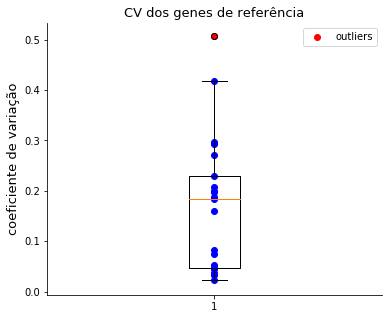

In [12]:
fig1 = plt.figure(figsize=(6,5))
i = 0
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("CV dos genes de referência", fontsize=13)
plt.ylabel("coeficiente de variação", fontsize=13)
for key in d_cv:
    if d_cv[key] <= upper_hkg and d_cv[key] >= lower_hkg:
        plt.scatter(1, d_cv[key], color="blue");
    else:
        plt.scatter(1, d_cv[key], color="red", label="outliers");
    i += 1
plt.boxplot(cv_values);
plt.legend();

In [13]:
print("max cv: ", upper_hkg)
print("------------ outliers -------------")
for key, val in d_cv.items():
    if val > upper_hkg or val < lower_hkg:
        print(key, val)
        
#X_train = X_train.drop("idnT")
X_train.shape

max cv:  0.5005366248219769
------------ outliers -------------
idnT 0.5082800362135752


(21, 9)

In [14]:
X_train = X_train.drop("idnT")

In [15]:
max_val = 1
min_val = -1
min_train = np.min(X_train)
max_train = np.max(X_train)
X_train = ((X_train - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


In [16]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [17]:
noise_input = 18
optimizerG = Adam(lr=0.0001, beta_1=0.5)
obj_G = Generator(noise_input, (9,), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()

Dimension del ruido de entrada:  18
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [18]:
G.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                950       
_________________________________________________________________
dense_1 (Dense)              (None, 150)               7650      
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1359      
_________________________________________________________________
reshape (Reshape)            (None, 9)                 0         
Total params: 9,959
Trainable params: 9,959
Non-trainable params: 0
_________________________________________________________________


In [19]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0], noise_input))
print("Dimension de los datos de entrada:", noise.shape)
data_fake = G.predict(noise)
print("Dimension de los ejemplos generados:", data_fake.shape)

Dimension de los datos de entrada: (20, 18)
Dimension de los ejemplos generados: (20, 9)


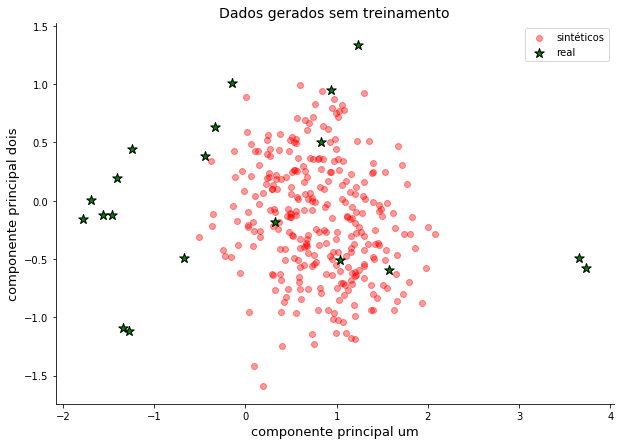

In [20]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)
X_train_pca
noise = np.random.normal(loc=0, scale=1, size=(300, noise_input))
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_fake_pca = pca_real.transform(x_noise)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="red", label="sintéticos", alpha=.4)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [21]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(32))
        model.add(Dropout(.1))
        model.add(Flatten())
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [22]:
optimizerD = Adam(lr=0.0001, beta_1=0.5)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [24]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [55]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    fscore = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_real = X_train.loc[np.random.choice(X_train.index.values, size=20, replace=False)]
        X_fake = G.predict(np.random.normal(0, 1, (20, noise_input)))
        X_test = np.concatenate((X_real, X_fake))
        y_test = np.concatenate((np.ones((20,1)), np.ones((20,1))))
        y_predict = D.predict_classes(X_test)
        #f1_lag = f1_score(y_test, y_predict)
        fscore.append(np.mean((y_predict - y_test)**2))
        #fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()
        #d_loss.append(np.mean(np.array(d_bacth_loss)))
        #g_loss.append(np.mean(np.array(g_bacth_loss)))
        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
        #if np.mean((D.predict(X_train) - np.ones((20,1)))**2) <= 0.15:
        #    break
    return g_loss, d_loss, fscore

In [166]:
noise_input = 50
#Gerador
#optimizerG = Adam(lr=0.0001, beta_1=0.4)
optimizerG = SGD(lr=0.00011, momentum=0.92, decay=0.0001/2000)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
#optimizerD = Adam(lr=0.002, beta_1=0.9)
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/2000)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_29 (Sequential)   (None, 9)                 11559     
_________________________________________________________________
sequential_30 (Sequential)   (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [167]:
ep = 2000
g_loss, d_loss, fscore = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D, gan=gan,
                       noise_input=noise_input)

epoch:[1/2000] [Discriminator::d_loss: 0.728720],[Generator::loss: 0.638209], 3.477681[sec]
epoch:[2/2000] [Discriminator::d_loss: 0.738268],[Generator::loss: 0.613141], 0.013305[sec]
epoch:[3/2000] [Discriminator::d_loss: 0.689347],[Generator::loss: 0.641319], 0.013529[sec]
epoch:[4/2000] [Discriminator::d_loss: 0.680361],[Generator::loss: 0.633236], 0.013280[sec]
epoch:[5/2000] [Discriminator::d_loss: 0.712257],[Generator::loss: 0.705734], 0.013349[sec]
epoch:[6/2000] [Discriminator::d_loss: 0.689014],[Generator::loss: 0.626239], 0.013729[sec]
epoch:[7/2000] [Discriminator::d_loss: 0.694313],[Generator::loss: 0.631812], 0.013359[sec]
epoch:[8/2000] [Discriminator::d_loss: 0.684966],[Generator::loss: 0.658109], 0.013686[sec]
epoch:[9/2000] [Discriminator::d_loss: 0.742170],[Generator::loss: 0.652676], 0.013615[sec]
epoch:[10/2000] [Discriminator::d_loss: 0.735415],[Generator::loss: 0.631361], 0.013307[sec]
epoch:[11/2000] [Discriminator::d_loss: 0.731383],[Generator::loss: 0.660834], 

epoch:[103/2000] [Discriminator::d_loss: 0.631367],[Generator::loss: 0.623461], 0.020254[sec]
epoch:[104/2000] [Discriminator::d_loss: 0.626944],[Generator::loss: 0.712223], 0.014777[sec]
epoch:[105/2000] [Discriminator::d_loss: 0.652302],[Generator::loss: 0.726000], 0.013576[sec]
epoch:[106/2000] [Discriminator::d_loss: 0.654639],[Generator::loss: 0.636610], 0.013372[sec]
epoch:[107/2000] [Discriminator::d_loss: 0.631225],[Generator::loss: 0.720444], 0.013198[sec]
epoch:[108/2000] [Discriminator::d_loss: 0.670998],[Generator::loss: 0.607542], 0.013103[sec]
epoch:[109/2000] [Discriminator::d_loss: 0.614549],[Generator::loss: 0.761178], 0.013129[sec]
epoch:[110/2000] [Discriminator::d_loss: 0.600552],[Generator::loss: 0.687518], 0.013127[sec]
epoch:[111/2000] [Discriminator::d_loss: 0.645023],[Generator::loss: 0.677587], 0.013187[sec]
epoch:[112/2000] [Discriminator::d_loss: 0.616635],[Generator::loss: 0.668649], 0.012967[sec]
epoch:[113/2000] [Discriminator::d_loss: 0.586812],[Generato

epoch:[193/2000] [Discriminator::d_loss: 0.590997],[Generator::loss: 0.736365], 0.014454[sec]
epoch:[194/2000] [Discriminator::d_loss: 0.584931],[Generator::loss: 0.908739], 0.017416[sec]
epoch:[195/2000] [Discriminator::d_loss: 0.637416],[Generator::loss: 0.743689], 0.013203[sec]
epoch:[196/2000] [Discriminator::d_loss: 0.600989],[Generator::loss: 0.817973], 0.013254[sec]
epoch:[197/2000] [Discriminator::d_loss: 0.599347],[Generator::loss: 0.739187], 0.013769[sec]
epoch:[198/2000] [Discriminator::d_loss: 0.615668],[Generator::loss: 0.882047], 0.013352[sec]
epoch:[199/2000] [Discriminator::d_loss: 0.638309],[Generator::loss: 0.752758], 0.013344[sec]
epoch:[200/2000] [Discriminator::d_loss: 0.597238],[Generator::loss: 0.760262], 0.013489[sec]
epoch:[201/2000] [Discriminator::d_loss: 0.645824],[Generator::loss: 0.813764], 0.013288[sec]
epoch:[202/2000] [Discriminator::d_loss: 0.576565],[Generator::loss: 0.765918], 0.013100[sec]
epoch:[203/2000] [Discriminator::d_loss: 0.648468],[Generato

epoch:[283/2000] [Discriminator::d_loss: 0.603674],[Generator::loss: 0.812009], 0.015108[sec]
epoch:[284/2000] [Discriminator::d_loss: 0.616692],[Generator::loss: 0.744633], 0.016240[sec]
epoch:[285/2000] [Discriminator::d_loss: 0.601435],[Generator::loss: 0.815570], 0.013632[sec]
epoch:[286/2000] [Discriminator::d_loss: 0.620734],[Generator::loss: 0.767858], 0.013428[sec]
epoch:[287/2000] [Discriminator::d_loss: 0.587052],[Generator::loss: 0.811186], 0.014937[sec]
epoch:[288/2000] [Discriminator::d_loss: 0.617384],[Generator::loss: 0.925070], 0.014108[sec]
epoch:[289/2000] [Discriminator::d_loss: 0.605547],[Generator::loss: 0.815330], 0.014772[sec]
epoch:[290/2000] [Discriminator::d_loss: 0.561113],[Generator::loss: 0.879111], 0.015149[sec]
epoch:[291/2000] [Discriminator::d_loss: 0.593252],[Generator::loss: 0.801354], 0.015095[sec]
epoch:[292/2000] [Discriminator::d_loss: 0.587750],[Generator::loss: 0.863594], 0.014709[sec]
epoch:[293/2000] [Discriminator::d_loss: 0.590874],[Generato

epoch:[377/2000] [Discriminator::d_loss: 0.527660],[Generator::loss: 0.786649], 0.019534[sec]
epoch:[378/2000] [Discriminator::d_loss: 0.619385],[Generator::loss: 0.914196], 0.019410[sec]
epoch:[379/2000] [Discriminator::d_loss: 0.605838],[Generator::loss: 0.920150], 0.014363[sec]
epoch:[380/2000] [Discriminator::d_loss: 0.593806],[Generator::loss: 0.930921], 0.013776[sec]
epoch:[381/2000] [Discriminator::d_loss: 0.614033],[Generator::loss: 0.885979], 0.013544[sec]
epoch:[382/2000] [Discriminator::d_loss: 0.597098],[Generator::loss: 0.931076], 0.013000[sec]
epoch:[383/2000] [Discriminator::d_loss: 0.553363],[Generator::loss: 0.798790], 0.013413[sec]
epoch:[384/2000] [Discriminator::d_loss: 0.543038],[Generator::loss: 0.881428], 0.013356[sec]
epoch:[385/2000] [Discriminator::d_loss: 0.554751],[Generator::loss: 0.972606], 0.013477[sec]
epoch:[386/2000] [Discriminator::d_loss: 0.543091],[Generator::loss: 0.783752], 0.013361[sec]
epoch:[387/2000] [Discriminator::d_loss: 0.591348],[Generato

epoch:[467/2000] [Discriminator::d_loss: 0.552399],[Generator::loss: 0.755344], 0.028868[sec]
epoch:[468/2000] [Discriminator::d_loss: 0.622465],[Generator::loss: 0.950219], 0.025055[sec]
epoch:[469/2000] [Discriminator::d_loss: 0.586632],[Generator::loss: 0.838690], 0.017874[sec]
epoch:[470/2000] [Discriminator::d_loss: 0.539816],[Generator::loss: 0.963769], 0.022791[sec]
epoch:[471/2000] [Discriminator::d_loss: 0.574441],[Generator::loss: 0.915649], 0.017339[sec]
epoch:[472/2000] [Discriminator::d_loss: 0.576982],[Generator::loss: 0.823559], 0.014170[sec]
epoch:[473/2000] [Discriminator::d_loss: 0.520917],[Generator::loss: 0.901961], 0.013385[sec]
epoch:[474/2000] [Discriminator::d_loss: 0.570952],[Generator::loss: 1.000289], 0.013516[sec]
epoch:[475/2000] [Discriminator::d_loss: 0.596442],[Generator::loss: 0.932656], 0.013295[sec]
epoch:[476/2000] [Discriminator::d_loss: 0.613620],[Generator::loss: 0.975150], 0.013332[sec]
epoch:[477/2000] [Discriminator::d_loss: 0.570845],[Generato

epoch:[556/2000] [Discriminator::d_loss: 0.548644],[Generator::loss: 0.964923], 0.019853[sec]
epoch:[557/2000] [Discriminator::d_loss: 0.512430],[Generator::loss: 0.872474], 0.018062[sec]
epoch:[558/2000] [Discriminator::d_loss: 0.584747],[Generator::loss: 0.912737], 0.014127[sec]
epoch:[559/2000] [Discriminator::d_loss: 0.573392],[Generator::loss: 0.973670], 0.013797[sec]
epoch:[560/2000] [Discriminator::d_loss: 0.571918],[Generator::loss: 1.020316], 0.013250[sec]
epoch:[561/2000] [Discriminator::d_loss: 0.538388],[Generator::loss: 0.871243], 0.013328[sec]
epoch:[562/2000] [Discriminator::d_loss: 0.609368],[Generator::loss: 0.954305], 0.013141[sec]
epoch:[563/2000] [Discriminator::d_loss: 0.595034],[Generator::loss: 0.852254], 0.033082[sec]
epoch:[564/2000] [Discriminator::d_loss: 0.569619],[Generator::loss: 0.938512], 0.022159[sec]
epoch:[565/2000] [Discriminator::d_loss: 0.566427],[Generator::loss: 0.902885], 0.019215[sec]
epoch:[566/2000] [Discriminator::d_loss: 0.548313],[Generato

epoch:[648/2000] [Discriminator::d_loss: 0.582088],[Generator::loss: 0.948975], 0.016154[sec]
epoch:[649/2000] [Discriminator::d_loss: 0.548739],[Generator::loss: 0.844173], 0.020609[sec]
epoch:[650/2000] [Discriminator::d_loss: 0.619166],[Generator::loss: 0.995165], 0.017541[sec]
epoch:[651/2000] [Discriminator::d_loss: 0.545633],[Generator::loss: 0.875648], 0.013754[sec]
epoch:[652/2000] [Discriminator::d_loss: 0.544704],[Generator::loss: 1.027657], 0.013659[sec]
epoch:[653/2000] [Discriminator::d_loss: 0.642861],[Generator::loss: 0.987542], 0.013849[sec]
epoch:[654/2000] [Discriminator::d_loss: 0.516778],[Generator::loss: 1.005840], 0.012896[sec]
epoch:[655/2000] [Discriminator::d_loss: 0.561280],[Generator::loss: 0.962552], 0.013489[sec]
epoch:[656/2000] [Discriminator::d_loss: 0.551714],[Generator::loss: 1.030383], 0.013184[sec]
epoch:[657/2000] [Discriminator::d_loss: 0.532607],[Generator::loss: 0.919744], 0.013243[sec]
epoch:[658/2000] [Discriminator::d_loss: 0.525331],[Generato

epoch:[748/2000] [Discriminator::d_loss: 0.571935],[Generator::loss: 0.965357], 0.016503[sec]
epoch:[749/2000] [Discriminator::d_loss: 0.549845],[Generator::loss: 0.946793], 0.016116[sec]
epoch:[750/2000] [Discriminator::d_loss: 0.565623],[Generator::loss: 0.936224], 0.013555[sec]
epoch:[751/2000] [Discriminator::d_loss: 0.628108],[Generator::loss: 0.915938], 0.014363[sec]
epoch:[752/2000] [Discriminator::d_loss: 0.599905],[Generator::loss: 0.904873], 0.013488[sec]
epoch:[753/2000] [Discriminator::d_loss: 0.563001],[Generator::loss: 0.872251], 0.013404[sec]
epoch:[754/2000] [Discriminator::d_loss: 0.577692],[Generator::loss: 0.757453], 0.013285[sec]
epoch:[755/2000] [Discriminator::d_loss: 0.520205],[Generator::loss: 0.951943], 0.013391[sec]
epoch:[756/2000] [Discriminator::d_loss: 0.609544],[Generator::loss: 0.957629], 0.013297[sec]
epoch:[757/2000] [Discriminator::d_loss: 0.577052],[Generator::loss: 0.918667], 0.013174[sec]
epoch:[758/2000] [Discriminator::d_loss: 0.583124],[Generato

epoch:[840/2000] [Discriminator::d_loss: 0.579826],[Generator::loss: 0.937746], 0.015194[sec]
epoch:[841/2000] [Discriminator::d_loss: 0.543609],[Generator::loss: 0.957307], 0.020046[sec]
epoch:[842/2000] [Discriminator::d_loss: 0.550477],[Generator::loss: 0.929567], 0.014074[sec]
epoch:[843/2000] [Discriminator::d_loss: 0.545098],[Generator::loss: 0.938414], 0.013928[sec]
epoch:[844/2000] [Discriminator::d_loss: 0.628477],[Generator::loss: 0.842860], 0.013421[sec]
epoch:[845/2000] [Discriminator::d_loss: 0.583021],[Generator::loss: 1.022707], 0.013412[sec]
epoch:[846/2000] [Discriminator::d_loss: 0.593935],[Generator::loss: 0.917096], 0.013259[sec]
epoch:[847/2000] [Discriminator::d_loss: 0.572390],[Generator::loss: 0.878568], 0.021796[sec]
epoch:[848/2000] [Discriminator::d_loss: 0.551469],[Generator::loss: 1.055173], 0.027046[sec]
epoch:[849/2000] [Discriminator::d_loss: 0.650989],[Generator::loss: 0.893765], 0.030933[sec]
epoch:[850/2000] [Discriminator::d_loss: 0.590094],[Generato

epoch:[930/2000] [Discriminator::d_loss: 0.595768],[Generator::loss: 0.924160], 0.022546[sec]
epoch:[931/2000] [Discriminator::d_loss: 0.595561],[Generator::loss: 0.921166], 0.021963[sec]
epoch:[932/2000] [Discriminator::d_loss: 0.660825],[Generator::loss: 1.021867], 0.023142[sec]
epoch:[933/2000] [Discriminator::d_loss: 0.582174],[Generator::loss: 0.849354], 0.021834[sec]
epoch:[934/2000] [Discriminator::d_loss: 0.629510],[Generator::loss: 0.917496], 0.021250[sec]
epoch:[935/2000] [Discriminator::d_loss: 0.613643],[Generator::loss: 0.759185], 0.025985[sec]
epoch:[936/2000] [Discriminator::d_loss: 0.652346],[Generator::loss: 1.025783], 0.023558[sec]
epoch:[937/2000] [Discriminator::d_loss: 0.631636],[Generator::loss: 0.893788], 0.021311[sec]
epoch:[938/2000] [Discriminator::d_loss: 0.615853],[Generator::loss: 0.856903], 0.029536[sec]
epoch:[939/2000] [Discriminator::d_loss: 0.597955],[Generator::loss: 1.009554], 0.026198[sec]
epoch:[940/2000] [Discriminator::d_loss: 0.653317],[Generato

epoch:[1018/2000] [Discriminator::d_loss: 0.622000],[Generator::loss: 1.039780], 0.014556[sec]
epoch:[1019/2000] [Discriminator::d_loss: 0.664374],[Generator::loss: 0.839862], 0.020060[sec]
epoch:[1020/2000] [Discriminator::d_loss: 0.703889],[Generator::loss: 0.967182], 0.013685[sec]
epoch:[1021/2000] [Discriminator::d_loss: 0.562342],[Generator::loss: 0.787005], 0.014082[sec]
epoch:[1022/2000] [Discriminator::d_loss: 0.648276],[Generator::loss: 1.012830], 0.012896[sec]
epoch:[1023/2000] [Discriminator::d_loss: 0.635589],[Generator::loss: 0.842535], 0.013508[sec]
epoch:[1024/2000] [Discriminator::d_loss: 0.699798],[Generator::loss: 0.716479], 0.014096[sec]
epoch:[1025/2000] [Discriminator::d_loss: 0.603215],[Generator::loss: 0.799644], 0.013210[sec]
epoch:[1026/2000] [Discriminator::d_loss: 0.664078],[Generator::loss: 0.729425], 0.013566[sec]
epoch:[1027/2000] [Discriminator::d_loss: 0.675739],[Generator::loss: 0.915736], 0.013402[sec]
epoch:[1028/2000] [Discriminator::d_loss: 0.639726

epoch:[1119/2000] [Discriminator::d_loss: 0.680729],[Generator::loss: 0.811188], 0.015616[sec]
epoch:[1120/2000] [Discriminator::d_loss: 0.770758],[Generator::loss: 0.739988], 0.019741[sec]
epoch:[1121/2000] [Discriminator::d_loss: 0.727048],[Generator::loss: 0.768876], 0.013845[sec]
epoch:[1122/2000] [Discriminator::d_loss: 0.655649],[Generator::loss: 0.846762], 0.014201[sec]
epoch:[1123/2000] [Discriminator::d_loss: 0.606404],[Generator::loss: 0.708897], 0.013613[sec]
epoch:[1124/2000] [Discriminator::d_loss: 0.672791],[Generator::loss: 0.818131], 0.014143[sec]
epoch:[1125/2000] [Discriminator::d_loss: 0.661121],[Generator::loss: 0.947165], 0.013675[sec]
epoch:[1126/2000] [Discriminator::d_loss: 0.685371],[Generator::loss: 0.963664], 0.013305[sec]
epoch:[1127/2000] [Discriminator::d_loss: 0.720799],[Generator::loss: 0.832312], 0.013646[sec]
epoch:[1128/2000] [Discriminator::d_loss: 0.651333],[Generator::loss: 0.958666], 0.013088[sec]
epoch:[1129/2000] [Discriminator::d_loss: 0.641774

epoch:[1216/2000] [Discriminator::d_loss: 0.688157],[Generator::loss: 0.837501], 0.015008[sec]
epoch:[1217/2000] [Discriminator::d_loss: 0.612074],[Generator::loss: 0.826877], 0.015022[sec]
epoch:[1218/2000] [Discriminator::d_loss: 0.645135],[Generator::loss: 0.820772], 0.014536[sec]
epoch:[1219/2000] [Discriminator::d_loss: 0.684328],[Generator::loss: 0.827746], 0.015376[sec]
epoch:[1220/2000] [Discriminator::d_loss: 0.673813],[Generator::loss: 0.867184], 0.014730[sec]
epoch:[1221/2000] [Discriminator::d_loss: 0.691527],[Generator::loss: 0.778520], 0.013702[sec]
epoch:[1222/2000] [Discriminator::d_loss: 0.675135],[Generator::loss: 0.834914], 0.013419[sec]
epoch:[1223/2000] [Discriminator::d_loss: 0.691405],[Generator::loss: 0.974975], 0.013310[sec]
epoch:[1224/2000] [Discriminator::d_loss: 0.683711],[Generator::loss: 0.813328], 0.013653[sec]
epoch:[1225/2000] [Discriminator::d_loss: 0.675373],[Generator::loss: 0.713649], 0.013829[sec]
epoch:[1226/2000] [Discriminator::d_loss: 0.632868

epoch:[1305/2000] [Discriminator::d_loss: 0.712800],[Generator::loss: 0.787867], 0.017976[sec]
epoch:[1306/2000] [Discriminator::d_loss: 0.675668],[Generator::loss: 0.694609], 0.018897[sec]
epoch:[1307/2000] [Discriminator::d_loss: 0.698710],[Generator::loss: 0.787145], 0.014176[sec]
epoch:[1308/2000] [Discriminator::d_loss: 0.690870],[Generator::loss: 0.814094], 0.013932[sec]
epoch:[1309/2000] [Discriminator::d_loss: 0.710413],[Generator::loss: 0.778501], 0.013908[sec]
epoch:[1310/2000] [Discriminator::d_loss: 0.610202],[Generator::loss: 0.770108], 0.014885[sec]
epoch:[1311/2000] [Discriminator::d_loss: 0.642718],[Generator::loss: 0.809870], 0.013716[sec]
epoch:[1312/2000] [Discriminator::d_loss: 0.654027],[Generator::loss: 0.834524], 0.013824[sec]
epoch:[1313/2000] [Discriminator::d_loss: 0.701047],[Generator::loss: 0.852137], 0.013416[sec]
epoch:[1314/2000] [Discriminator::d_loss: 0.705803],[Generator::loss: 0.778402], 0.013413[sec]
epoch:[1315/2000] [Discriminator::d_loss: 0.701491

epoch:[1395/2000] [Discriminator::d_loss: 0.678436],[Generator::loss: 0.882644], 0.016481[sec]
epoch:[1396/2000] [Discriminator::d_loss: 0.693849],[Generator::loss: 0.720666], 0.019388[sec]
epoch:[1397/2000] [Discriminator::d_loss: 0.626148],[Generator::loss: 0.792320], 0.014102[sec]
epoch:[1398/2000] [Discriminator::d_loss: 0.667196],[Generator::loss: 0.740857], 0.014080[sec]
epoch:[1399/2000] [Discriminator::d_loss: 0.696931],[Generator::loss: 0.782943], 0.013666[sec]
epoch:[1400/2000] [Discriminator::d_loss: 0.658443],[Generator::loss: 0.818103], 0.013385[sec]
epoch:[1401/2000] [Discriminator::d_loss: 0.721742],[Generator::loss: 0.798720], 0.013585[sec]
epoch:[1402/2000] [Discriminator::d_loss: 0.686465],[Generator::loss: 0.832874], 0.013542[sec]
epoch:[1403/2000] [Discriminator::d_loss: 0.700270],[Generator::loss: 0.731433], 0.013388[sec]
epoch:[1404/2000] [Discriminator::d_loss: 0.727133],[Generator::loss: 0.630811], 0.013617[sec]
epoch:[1405/2000] [Discriminator::d_loss: 0.647608

epoch:[1493/2000] [Discriminator::d_loss: 0.697136],[Generator::loss: 0.821374], 0.015735[sec]
epoch:[1494/2000] [Discriminator::d_loss: 0.709239],[Generator::loss: 0.762398], 0.017979[sec]
epoch:[1495/2000] [Discriminator::d_loss: 0.673662],[Generator::loss: 0.685753], 0.016666[sec]
epoch:[1496/2000] [Discriminator::d_loss: 0.739833],[Generator::loss: 0.720556], 0.014228[sec]
epoch:[1497/2000] [Discriminator::d_loss: 0.702385],[Generator::loss: 0.778484], 0.013180[sec]
epoch:[1498/2000] [Discriminator::d_loss: 0.662368],[Generator::loss: 0.718980], 0.013623[sec]
epoch:[1499/2000] [Discriminator::d_loss: 0.732055],[Generator::loss: 0.740566], 0.013343[sec]
epoch:[1500/2000] [Discriminator::d_loss: 0.739611],[Generator::loss: 0.803734], 0.013196[sec]
epoch:[1501/2000] [Discriminator::d_loss: 0.746512],[Generator::loss: 0.711273], 0.013256[sec]
epoch:[1502/2000] [Discriminator::d_loss: 0.738465],[Generator::loss: 0.838934], 0.013041[sec]
epoch:[1503/2000] [Discriminator::d_loss: 0.718205

epoch:[1586/2000] [Discriminator::d_loss: 0.681719],[Generator::loss: 0.783547], 0.016212[sec]
epoch:[1587/2000] [Discriminator::d_loss: 0.678586],[Generator::loss: 0.747816], 0.015128[sec]
epoch:[1588/2000] [Discriminator::d_loss: 0.633883],[Generator::loss: 0.679993], 0.016074[sec]
epoch:[1589/2000] [Discriminator::d_loss: 0.695280],[Generator::loss: 0.735858], 0.021142[sec]
epoch:[1590/2000] [Discriminator::d_loss: 0.705081],[Generator::loss: 0.732629], 0.017230[sec]
epoch:[1591/2000] [Discriminator::d_loss: 0.682167],[Generator::loss: 0.881999], 0.018062[sec]
epoch:[1592/2000] [Discriminator::d_loss: 0.695286],[Generator::loss: 0.780685], 0.014072[sec]
epoch:[1593/2000] [Discriminator::d_loss: 0.738250],[Generator::loss: 0.834058], 0.013581[sec]
epoch:[1594/2000] [Discriminator::d_loss: 0.714119],[Generator::loss: 0.706959], 0.013583[sec]
epoch:[1595/2000] [Discriminator::d_loss: 0.706750],[Generator::loss: 0.768693], 0.013285[sec]
epoch:[1596/2000] [Discriminator::d_loss: 0.661962

epoch:[1675/2000] [Discriminator::d_loss: 0.732351],[Generator::loss: 0.699212], 0.015729[sec]
epoch:[1676/2000] [Discriminator::d_loss: 0.689859],[Generator::loss: 0.780415], 0.015694[sec]
epoch:[1677/2000] [Discriminator::d_loss: 0.729270],[Generator::loss: 0.761817], 0.013891[sec]
epoch:[1678/2000] [Discriminator::d_loss: 0.675620],[Generator::loss: 0.690547], 0.013589[sec]
epoch:[1679/2000] [Discriminator::d_loss: 0.712786],[Generator::loss: 0.769444], 0.013169[sec]
epoch:[1680/2000] [Discriminator::d_loss: 0.694629],[Generator::loss: 0.780756], 0.013359[sec]
epoch:[1681/2000] [Discriminator::d_loss: 0.677087],[Generator::loss: 0.732467], 0.013307[sec]
epoch:[1682/2000] [Discriminator::d_loss: 0.668207],[Generator::loss: 0.681759], 0.013489[sec]
epoch:[1683/2000] [Discriminator::d_loss: 0.685194],[Generator::loss: 0.755748], 0.013168[sec]
epoch:[1684/2000] [Discriminator::d_loss: 0.682969],[Generator::loss: 0.702072], 0.013175[sec]
epoch:[1685/2000] [Discriminator::d_loss: 0.659329

epoch:[1765/2000] [Discriminator::d_loss: 0.710062],[Generator::loss: 0.787458], 0.015461[sec]
epoch:[1766/2000] [Discriminator::d_loss: 0.671155],[Generator::loss: 0.779268], 0.015298[sec]
epoch:[1767/2000] [Discriminator::d_loss: 0.700078],[Generator::loss: 0.748738], 0.014125[sec]
epoch:[1768/2000] [Discriminator::d_loss: 0.705949],[Generator::loss: 0.752089], 0.013852[sec]
epoch:[1769/2000] [Discriminator::d_loss: 0.689969],[Generator::loss: 0.739970], 0.013629[sec]
epoch:[1770/2000] [Discriminator::d_loss: 0.672330],[Generator::loss: 0.746624], 0.013543[sec]
epoch:[1771/2000] [Discriminator::d_loss: 0.670165],[Generator::loss: 0.707780], 0.013505[sec]
epoch:[1772/2000] [Discriminator::d_loss: 0.670647],[Generator::loss: 0.722524], 0.012996[sec]
epoch:[1773/2000] [Discriminator::d_loss: 0.680711],[Generator::loss: 0.773138], 0.013250[sec]
epoch:[1774/2000] [Discriminator::d_loss: 0.686231],[Generator::loss: 0.799281], 0.013156[sec]
epoch:[1775/2000] [Discriminator::d_loss: 0.720306

epoch:[1859/2000] [Discriminator::d_loss: 0.681183],[Generator::loss: 0.728724], 0.015857[sec]
epoch:[1860/2000] [Discriminator::d_loss: 0.673071],[Generator::loss: 0.741522], 0.016251[sec]
epoch:[1861/2000] [Discriminator::d_loss: 0.691417],[Generator::loss: 0.740960], 0.013627[sec]
epoch:[1862/2000] [Discriminator::d_loss: 0.692767],[Generator::loss: 0.799418], 0.013344[sec]
epoch:[1863/2000] [Discriminator::d_loss: 0.687769],[Generator::loss: 0.702424], 0.013630[sec]
epoch:[1864/2000] [Discriminator::d_loss: 0.679806],[Generator::loss: 0.788925], 0.013417[sec]
epoch:[1865/2000] [Discriminator::d_loss: 0.686527],[Generator::loss: 0.707581], 0.014145[sec]
epoch:[1866/2000] [Discriminator::d_loss: 0.692501],[Generator::loss: 0.754297], 0.015900[sec]
epoch:[1867/2000] [Discriminator::d_loss: 0.687724],[Generator::loss: 0.777839], 0.020150[sec]
epoch:[1868/2000] [Discriminator::d_loss: 0.692207],[Generator::loss: 0.785472], 0.019891[sec]
epoch:[1869/2000] [Discriminator::d_loss: 0.666451

epoch:[1947/2000] [Discriminator::d_loss: 0.648689],[Generator::loss: 0.771622], 0.014768[sec]
epoch:[1948/2000] [Discriminator::d_loss: 0.687167],[Generator::loss: 0.743450], 0.014627[sec]
epoch:[1949/2000] [Discriminator::d_loss: 0.699214],[Generator::loss: 0.716557], 0.015310[sec]
epoch:[1950/2000] [Discriminator::d_loss: 0.687895],[Generator::loss: 0.731039], 0.013884[sec]
epoch:[1951/2000] [Discriminator::d_loss: 0.692074],[Generator::loss: 0.694719], 0.013325[sec]
epoch:[1952/2000] [Discriminator::d_loss: 0.681480],[Generator::loss: 0.748978], 0.013253[sec]
epoch:[1953/2000] [Discriminator::d_loss: 0.667072],[Generator::loss: 0.734749], 0.014585[sec]
epoch:[1954/2000] [Discriminator::d_loss: 0.673777],[Generator::loss: 0.716342], 0.013402[sec]
epoch:[1955/2000] [Discriminator::d_loss: 0.673710],[Generator::loss: 0.734026], 0.013242[sec]
epoch:[1956/2000] [Discriminator::d_loss: 0.693264],[Generator::loss: 0.722934], 0.013180[sec]
epoch:[1957/2000] [Discriminator::d_loss: 0.686157

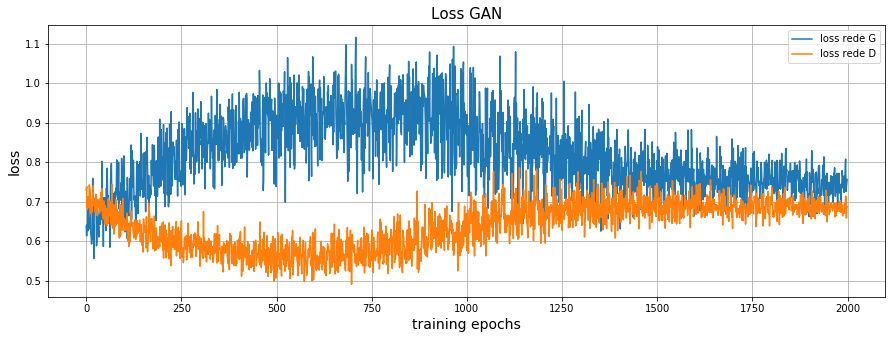

In [168]:
plt.figure(figsize=(15,5))
plt.title("Loss GAN", fontsize=15)
plt.plot(range(len(g_loss)), g_loss, label="loss rede G")
plt.plot(range(len(d_loss)), d_loss, label="loss rede D")
plt.xlabel("training epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

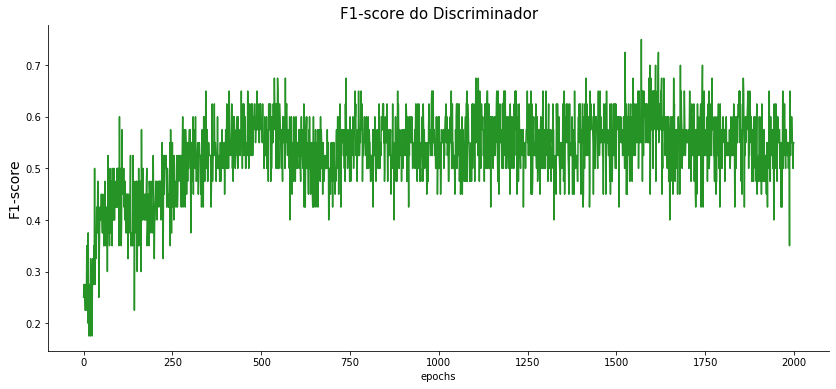

In [169]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("F1-score do Discriminador", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("F1-score", fontsize=14)
plt.plot(range(len(fscore)), fscore, color="green", alpha=.85);

(20, 2) (300, 2)


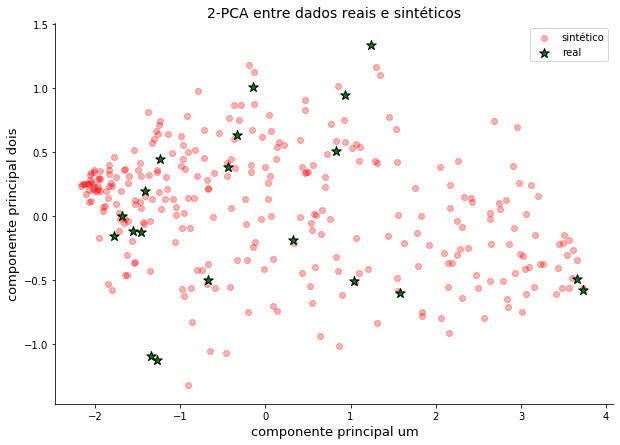

In [273]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(loc=0, scale=1, size=(300, noise_input)))
X_fake_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_fake_pca.shape)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [248]:
score = []
for i in range(5000):
    X_sint = G.predict(np.random.normal(0, 1, (100, noise_input)))
    X_test = np.concatenate((X_train, X_sint))
    y_test = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((100,1))))
    y_predict = D.predict_classes(X_test)
    score.append(np.mean((y_test - y_predict)**2))

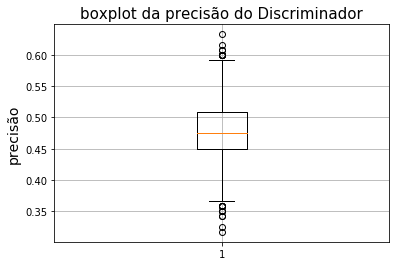

In [249]:
plt.title("boxplot da precisão do Discriminador", fontsize=15)
plt.ylabel("precisão", fontsize=14)
plt.grid("y")
plt.boxplot(score);

In [250]:
np.mean(score), np.std(score), np.median(score)

(0.4780049999999999, 0.0416094337260194, 0.475)

In [276]:
X_sint = G.predict(np.random.normal(0, 1, (300, noise_input)))
X_nov = np.concatenate((X_train.iloc[:10], X_sint))

In [297]:
from sklearn.svm import OneClassSVM

clf = OneClassSVM(kernel="rbf", nu=0.1, gamma=.1).fit(X_train)

np.mean(clf.predict(X_train.iloc[10:]) == 1)

0.9

In [298]:
np.mean(clf.predict(X_train)==1)

0.8

In [258]:
datos = ((datos - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
datos.shape

(4293, 9)

In [259]:
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,-1.021960,-0.979435,-1.070980,-0.936075,-0.964250,-1.031994,-0.934337,-0.939543,-0.937269
aaeB,-1.009480,-1.042995,-1.041304,-1.034891,-1.060889,-1.063096,-1.039629,-0.965042,-0.989310
aaeR,-1.006916,-0.996388,-1.082667,-0.987112,-1.078005,-1.014922,-1.058494,-0.940447,0.509951
aaeX,-0.943096,-0.955260,-0.950883,-0.910106,0.425601,-1.000392,-1.010278,-0.964826,0.441659
aas,-0.922192,-0.918634,-0.912901,-0.955073,-0.996782,-0.974946,-0.973578,-0.897515,-0.892211


In [260]:
datos = datos.drop(hkg)
datos.shape

(4272, 9)

In [261]:
cand_cv = dict()
for idx, val in datos.iterrows():
    cand_cv[idx] = np.std(val)/np.mean(val)

In [299]:
predict_cand = clf.predict(datos)

In [300]:
cand = datos[predict_cand == 1]
no_cand = datos[predict_cand == -1]

In [301]:
predict_cand

array([ 1, -1, -1, ...,  1, -1, -1])

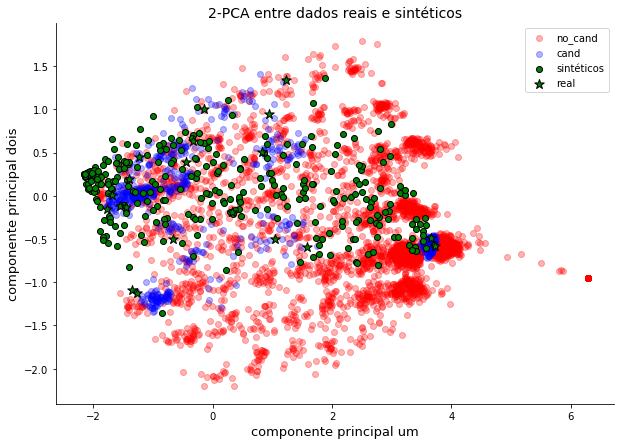

In [302]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand[:,0], X_cand[:,1], color="blue", label="cand",alpha=.3)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="green", label="sintéticos",alpha=1, edgecolors="black")
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [303]:
X_cand.shape[0]

747

In [304]:
cand

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,-1.021960,-0.979435,-1.070980,-0.936075,-0.964250,-1.031994,-0.934337,-0.939543,-0.937269
aas,-0.922192,-0.918634,-0.912901,-0.955073,-0.996782,-0.974946,-0.973578,-0.897515,-0.892211
accB,-0.514109,0.918962,1.020704,0.785425,0.781750,0.679621,0.702075,0.594880,0.713118
acpP,0.240181,0.238228,0.358745,0.258240,0.250706,0.181512,0.155418,-0.072485,0.131388
acrZ,-0.346667,-0.275970,-0.137655,-0.180062,-0.207965,-0.233707,-0.233449,-0.332987,-0.233845
...,...,...,...,...,...,...,...,...,...
ytjC,-0.903228,-0.941950,-0.867201,-0.962170,-0.963879,-0.980938,-0.997081,-0.920845,-0.925040
zapA,0.692970,0.692621,0.711157,0.804052,-0.675645,0.769246,0.742619,0.602742,0.666505
zapB,0.071121,0.054949,0.178200,0.116346,0.132872,0.030186,0.053554,-0.273880,-0.022717


In [305]:
obj_rg = open("./data/RG_artigoMoose.txt")
rg_moose = [g for g in obj_rg.read().splitlines()]
print("Genes candidatos do artigo moose:", len(rg_moose))
print(rg_moose)

Genes candidatos do artigo moose: 27
['dnaG', 'dtpB', 'ftsX', 'ftsY', 'glyY', 'gyrB', 'lhr', 'mutM', 'mutY', 'ndk', 'nfuA', 'pnp', 'rbbA', 'rhsB', 'rpsU', 'rrsE', 'rrsG', 'secB', 'spoT', 'tfaR', 'thrW', 'valS', 'yedJ', 'ynaE', 'yphG', 'zntA', 'zupT']


In [306]:
cand.loc[rg_moose].dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
rrsE,0.587656,0.604759,0.693686,0.763962,0.745445,0.692236,0.564757,0.333634,0.588330
rrsG,-0.340691,-0.307542,-0.218399,-0.166913,-0.192341,-0.278790,-0.419332,0.789914,-0.380720
spoT,0.884382,0.884552,0.940746,0.896704,0.886937,0.848056,0.782912,0.707923,0.829242
thrW,-0.198341,-0.156393,-0.103735,-0.003529,-0.075905,-0.175493,-0.166364,1.018885,-0.263904
zupT,-0.722573,0.721750,0.753271,0.759741,0.757655,0.733104,0.654379,0.607526,0.687909


In [307]:
obj_edi = open("data/RG_artigoEdian.txt")
rg_edi = [g for g in obj_edi.read().splitlines()]
print("Genes candidatos do artigo edian:", len(rg_edi))
print(rg_edi)

Genes candidatos do artigo edian: 17
['bamD', 'efp', 'gatB', 'gatD', 'hfq', 'nusA', 'polA', 'prc', 'prfB', 'ptsN', 'rimP', 'rplP', 'rpsC', 'rpsO', 'rpsU', 'slyD', 'ychF']


In [308]:
c = 0
for i in rg_edi:
    if i in rg_moose:
        print(i)
        c += 1

rpsU


In [309]:
cand.loc[rg_edi].dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
gatD,0.797513,0.779422,0.864410,0.888021,0.879034,0.811774,0.696794,0.558069,0.723031
ptsN,0.788705,0.766796,0.808711,0.881338,0.850952,0.785160,0.660781,0.588654,0.714060
